# Биффуркационный анализ - совмещение сосудов

In [13]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import det
from scipy.optimize import fsolve
import math
from numpy.linalg import det, inv, svd, norm
import math

In [14]:
def dV(Q):
    return Q

def dQ(V, Q, R, C, I=0.00003):
    T = 2.1
    return -T * R / I * Q - T**2/ I / C * V

def system(main_var, params):
    V, Q = main_var
    R, _, C = params   
    return np.array([dV(Q), dQ(V, Q, R, C)])

In [15]:
def analyse_point(F):
    eps = 10**(-4)
    dets = []
    for col in range(len(F[0])):
        cols = [i for i in range(len(F[0])) if i != col]
        dets.append(det(F[:, cols]))
    if (np.abs(dets) < eps).all():
        return True, np.round(dets, 4)
    return False, np.round(dets, 4)

def parameter_change(p_idx, diff, x_cur, y_cur, x_next):
  max_idx = np.argmax(diff)
  id_p = 0
  id_diff = 0
  for i in range(len(x_cur)): 
    if x_cur[i] == p_idx:
      id_p = i
    if x_cur[i] == max_idx:
      id_diff = i
  x_cur[id_p] , x_cur[id_diff] = x_cur[id_diff] , x_cur[id_p]

def continuation_parameter(Xs, Ys, x_cur, y_cur, x_next):
    if len(Ys) < 3:
        Ys.append(y_cur)
        Xs.append(x_cur)
    else:
        Ys[0], Ys[1], Ys[2] = Ys[1], Ys[2], y_cur
        Xs[0], Xs[1], Xs[2] = Xs[1], Xs[2], x_cur
    a0 = Ys[0]
    if len(Ys) == 1: 
      return a0
    a1 = (Ys[1] - Ys[0])/(Xs[1]-Xs[0])
    if len(Ys) == 2: 
      return a0 + a1*(x_next-Xs[0])
    yx1x2 = (Ys[2]-Ys[1])/(Xs[2]-Xs[1])
    a2 = (yx1x2 - a1)/(Xs[2]-Xs[0])
    y_next = a0 + a1*(x_next-Xs[0]) + a2*(x_next-Xs[0])*(x_next-Xs[1])
    return y_next

def biff_branch_searcher(start_parameter, x_cur, y_cur, x_next):
  while 1 == 1:
    p, diff, is_inf = continuation_parameter(start_parameter[0],start_parameter[1], x_cur, y_cur, x_next)
    if is_inf:
      break
    print('Parameter change')
    parameter_change(p, diff,x_cur, x_cur, y_cur, x_next)

In [16]:



def error(left, right, params):    
    V10, Q10, V20, Q20 = left 
    V11, Q11, V21, Q21 = right
    C1, C2 = params[2][0], params[2][1]
    S1, S2 = params[1][0], params[1][1]
    v01, v02 = 2650, 3000
    ro = 1
    T1 = 2.1
    T2 = 2.1   
    # Сохранение масс
    mass1 = v01*Q10 / T1 - v02*Q21 / T2
    mass2 = v01*Q11 / T1 - v02*Q20 / T2
    # Бернулли
    moment1 = (v01*Q10/math.sqrt(2)/T1/S1)**2 + v01*V10/ro/C1 - (v02*Q21/math.sqrt(2)/T2/S2)**2 + v02*V21/ro/C2 + 9
    moment2 = (v01*Q11/math.sqrt(2)/T1/S1)**2 + v01*V11/ro/C1 - (v02*Q20/math.sqrt(2)/T2/S2)**2 + v02*V20/ro/C2
    
    return np.array([mass1, mass2, moment1, moment2])
    
    

def RungeKutta(t0, t1,y_init,params,system = system,n = 5000):  
    y0 = y_init.copy().astype(float)
    T = 2.1
    t0 /= T
    t1 /= T 
    h = (t1 - t0) / n    
    for i in range(n):
        k1 = system(y0, params)
        k2 = system(y0 + k1 * h/2, params)
        k3 = system(y0 + k2 * h/2, params)
        k4 = system(y0 + k3 * h, params)
        k = h * (k1 + 2*k2 + 2*k3 + k4) / 6       
        y0 += k
        return y0

def shoot(y_init,params,system = system,solver = RungeKutta,error = error,eps = 10**(-4),delta = 10**(-5)):
    yt = np.array(y_init).astype(np.float32)   
    cnt = 0
    D = np.nan
    J = np.nan
    conv = 0
    while True:
        cnt += 1
        y1, y2 = yt[:2], yt[2:]
        left1 = solver(0.5, 0, y1, params[:, 0], system)
        left2 = solver(1.5, 0.8, y2, params[:, 1], system)
        left = np.concatenate([left1, left2])    
        right1 = solver(0.5, 0.8, y1, params[:, 0], system)
        right2 = solver(1.5, 2.1, y2, params[:, 1], system)
        right = np.concatenate([right1, right2])
        err = error(left, right, params)
        if (abs(err) < delta).all():
             break
        J = np.empty((len(err), len(yt)))
        for i in range(len(yt)):
            yi = yt.copy()
            yi[i] += eps
            y1, y2 = yi[:2], yi[2:]
            l1 = solver(0.5, 0, y1, params[:, 0], system)
            l2 = solver(1.5, 0.8, y2, params[:, 1], system)
            left = np.concatenate([l1, l2])
            r1 = solver(0.5, 0.8, y1, params[:, 0], system)
            r2 = solver(1.5, 2.1, y2, params[:, 1], system)
            right = np.concatenate([r1, r2])
            # подсчет матрицы Фреше
            J[:, i] = (error(left, right, params) - err) / eps
        try:
            D = det(J)
            # Критическая зона
            if (abs(det(J)) < 10**(-10)):
                conv = 1
                break
            yt -= np.dot(np.linalg.inv(J),  err)
        except:
            break
        if cnt == 10:
            break
    return cnt, conv, yt, np.linalg.norm(yt), J, D, err

In [7]:
Graph = np.array([[1], [2], [3], [4], [0]])
Graph = Graph[[0, 4]]
avg_normal_params = np.array([[0.25, 0.3],
                              [265, 300], 
                              [0.2, 0.25]])
full_ranges = np.array([[[0.0005, 0.05], [0.0005, 0.05]],
                        [[200, 400], [100, 300]],
                        [[0, 0.4], [0, 0.3]]])


full_lins = []
for i, dim in enumerate(full_ranges):
    for j, ves in enumerate(dim):
        full_lins.append(np.linspace(ves[0], ves[1], 10))
full_lins = np.array(full_lins).reshape((3, len(Graph), 10))

temp_params = np.array([0.15, 0.15, 220., 
                        250., 0.01, 0.01]).reshape(3, 2)

y = np.array([20., 0, 0, 0])
shoot(y, params = temp_params)

(2,
 1,
 array([ 9.9174519e+00, -2.2032361e-02, -8.7802238e+00,  4.6503823e+03],
       dtype=float32),
 4650.4014,
 array([[ 1.14098605e+06,  2.05086926e+03,  8.95694733e+05,
          0.00000000e+00],
        [-4.57573307e+05,  9.28644864e+02, -2.00648284e+06,
          0.00000000e+00],
        [ 2.66655372e+08,  4.78814352e+05,  1.63586031e+08,
          0.00000000e+00],
        [ 4.31080013e+07, -8.69450864e+04,  1.46983016e+08,
          0.00000000e+00]]),
 0.0,
 array([-9.39605731e+04,  3.76821917e+04,  2.80601158e+08,  4.50763084e+07]))

In [ ]:
R_1_range = [0.15, 0.25, 0.5]
R_2_range = [0.15, 0.3, 0.5]
S_1_range = [220, 265, 320]
S_2_range = [250, 300, 380]
C_1 = [0.01, 0.3]
C_2 = [0.01, 0.4]

normal_ranges = np.array([[0.2, 0.3], [0.25, 0.4], [250, 280],
                        [285, 340], [0.1, 0.25], [0.2, 0.3]])

def is_normal(arr):
    res = np.ones(len(arr))
    for i, elem in enumerate(arr):
        lb, rb = normal_ranges[i][0], normal_ranges[i][1]
        res[i] = int((elem >= lb) and (elem <= rb))
    return res

np.set_printoptions(suppress=True)

In [ ]:
data_frame = []
plots = []
cnt = 0
for r1 in R_1_range:
    for r2 in R_2_range:
        for s1 in S_1_range:
            for s2 in S_2_range:
                for c2 in [0.01, 0.25, 0.4]:
                    norms = []
                    Ds = []
                    for c1 in np.linspace(C_1[0], C_1[1], 30):
                        params = np.array([[r1, r2],[s1, s2], [c1, c2]]) 
                        cnt2, conv, yt, norm, J, D, err = shoot([20., 0., 0., 0.], params = params)
                        is_norm = is_normal(params.flatten())
                        data_frame.append([conv, cnt2, yt, norm, J, D,params.flatten(), is_norm, np.round(err, 3)]) 
                        norms.append(norm)
                        Ds.append(D)                                          
                    plots.append((norms, Ds, is_norm))
                    cnt += 1
        

In [ ]:
df = pd.DataFrame(data_frame, columns = ['conv', 'its', 'yt', 'norm', 'J', 'D',
                                           'params', 'is_norm_params', 'err'])

,conv,its,yt,norm,J,D,params,is_norm_params,err
0,1,2,"[9.917452, -0.022032361, -8.780224, 4650.3823]",4650.401367,"[[1140986.051801592, 2050.869259983301, 895694...",0.000000e+00,"[0.15, 0.15, 220.0, 250.0, 0.01, 0.01]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-93960.573, 37682.192, 280601157.951, 4507630..."
1,1,2,"[9.917295, -0.029814536, -4.401101, 2332.2559]",2332.281006,"[[572028.6733563989, 2065.5038207769394, 89569...",0.000000e+00,"[0.15, 0.15, 220.0, 250.0, 0.01999999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-47107.792, 18859.574, 70548253.695, 11280288..."
2,0,10,"[0.11619779, -202.74303, 0.25308755, -250.96988]",322.630890,"[[381239.3066252116, 1895.5005053430796, 89449...",-3.425785e+19,"[0.15, 0.15, 220.0, 250.0, 0.03, 0.01]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-146414.347, 19390.966, 2549724.666, 833794.59]"
3,1,6,"[0.7790616, 6688.4424, -8.55534, 8368.825]",10713.196289,"[[286057.2982765734, 0.0, 895694.7326660156, 0...",0.000000e+00,"[0.15, 0.15, 220.0, 250.0, 0.03999999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[62782.808, -141800.318, 474213491.825, 714830..."
4,0,10,"[-0.44297415, 19.926523, 0.052833527, -16.651642]",25.971956,"[[228907.1913670341, 2057.336988073075, 894495...",1.060458e+17,"[0.15, 0.15, 220.0, 250.0, 0.04999999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-287.523, -138.803, 1180.632, 2311.229]"
...,...,...,...,...,...,...,...,...,...
7285,1,5,"[-569.79224, 8944.11, -628.9425, 6295.2827]",10970.320312,"[[103217.26243942976, 0.0, 12207.03125, 0.0], ...",0.000000e+00,"[0.5, 0.5, 320.0, 380.0, 0.25999999999999995, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[627981.024, 6219262.966, 170732940.055, 53790..."
7286,0,10,"[3.5195, -63.11203, 18.335873, -176.54211]",188.411346,"[[80758.42152931727, 5946.2919377256185, 10013...",-1.611110e+17,"[0.5, 0.5, 320.0, 380.0, 0.26999999999999996, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-322379.883, -7113.947, 1468461.611, 586517.009]"
7287,0,10,"[-46.537125, 476.27032, 21.039469, -138.64702]",498.662994,"[[78623.40810068417, 6937.423954368569, 9989.7...",-2.055412e+16,"[0.5, 0.5, 320.0, 380.0, 0.27999999999999997, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-266311.47, 113231.353, 591868.377, -25330.661]"
7288,1,8,"[317.90155, -1902.9187, -778.26953, 7561.8574]",7842.802734,"[[69405.84110096097, 7928.573228418827, 12207....",0.000000e+00,"[0.5, 0.5, 320.0, 380.0, 0.29, 0.4]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[361134.678, -7988793.766, 221737877.236, 5592..."


In [9]:
#def bifan(params, debug=False):
    
#     bif_map = []
#     n_params = len(params)
#     for i, p in enumerate(params):                        
#         cnt, yt, D = shoot(0, 1, params=p)
#         sgn = np.sign(D)
#         bif_map.append(D)
        
#         if debug:
#             print(f'{i+1}/{n_params}   D = {D}')   
#     return bif_map
# BIF_MAPS = np.array([])
pairs = [list(i) for i in (itertools.combinations(range(len(Graph) * 3), 2))]

# dm_map = ['R', 'S', 'C']
    
# for cnt, p in enumerate(pairs):
#     dm1, ves1, dm2, ves2 = p[0] // len(Graph), p[0] % len(Graph), p[1] // len(Graph), p[1] % len(Graph)
    
#     range_1 = full_lins[dm1, ves1]
#     range_2 = full_lins[dm2, ves2]
#     params = avg_normal_params.copy()
    
#     bif_params = []
    
#     for p1 in range_1:
#         for p2 in range_2:
#             params[dm1, ves1] = p1
#             params[dm2, ves2] = p2
#             bif_params.append(params.copy())            
#     print([dm_map[dm1], ves1 + 1, dm_map[dm2], ves2 + 1])
#     bif_map = bifan(bif_params)
#     break
#     BIF_MAPS = np.append(BIF_MAPS, bif_map)
# BIF_MAPS = bif.reshape((15, 10, 10))
# with open('bifmaps_norm.npy', 'wb') as f:
#     np.save(f, BIF_MAPS)

## Биффуркационные карты и графики детерминанта

[0.         0.04444444 0.08888889 0.13333333 0.17777778 0.22222222
 0.26666667 0.31111111 0.35555556 0.4       ]


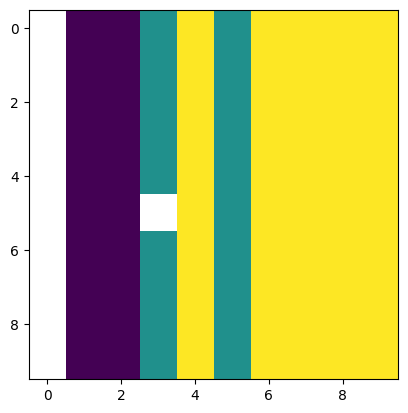

In [12]:
import matplotlib.pyplot as plt

with open('bifurc_maps.npy', 'rb') as file:
    BIF_MAPS = np.load(file)

BIF_MAPS_sgn = np.sign(BIF_MAPS)
plt.imshow(BIF_MAPS_sgn[3]);
dm_map = ['R', 'S', 'C']
xlabels = []
ylabels = []
for cnt, p in enumerate(pairs):
    dm1, ves1, dm2, ves2 = p[0] // len(Graph), p[0] % len(Graph), p[1] // len(Graph), p[1] % len(Graph)
    ylabels.append(' '.join(str(i) for i in [dm_map[dm1], ves1 + 1]))
    xlabels.append(' '.join(str(i) for i in [dm_map[dm2], ves2 + 1]))
    
    if cnt == 3:
        print(full_lins[dm2, ves2])

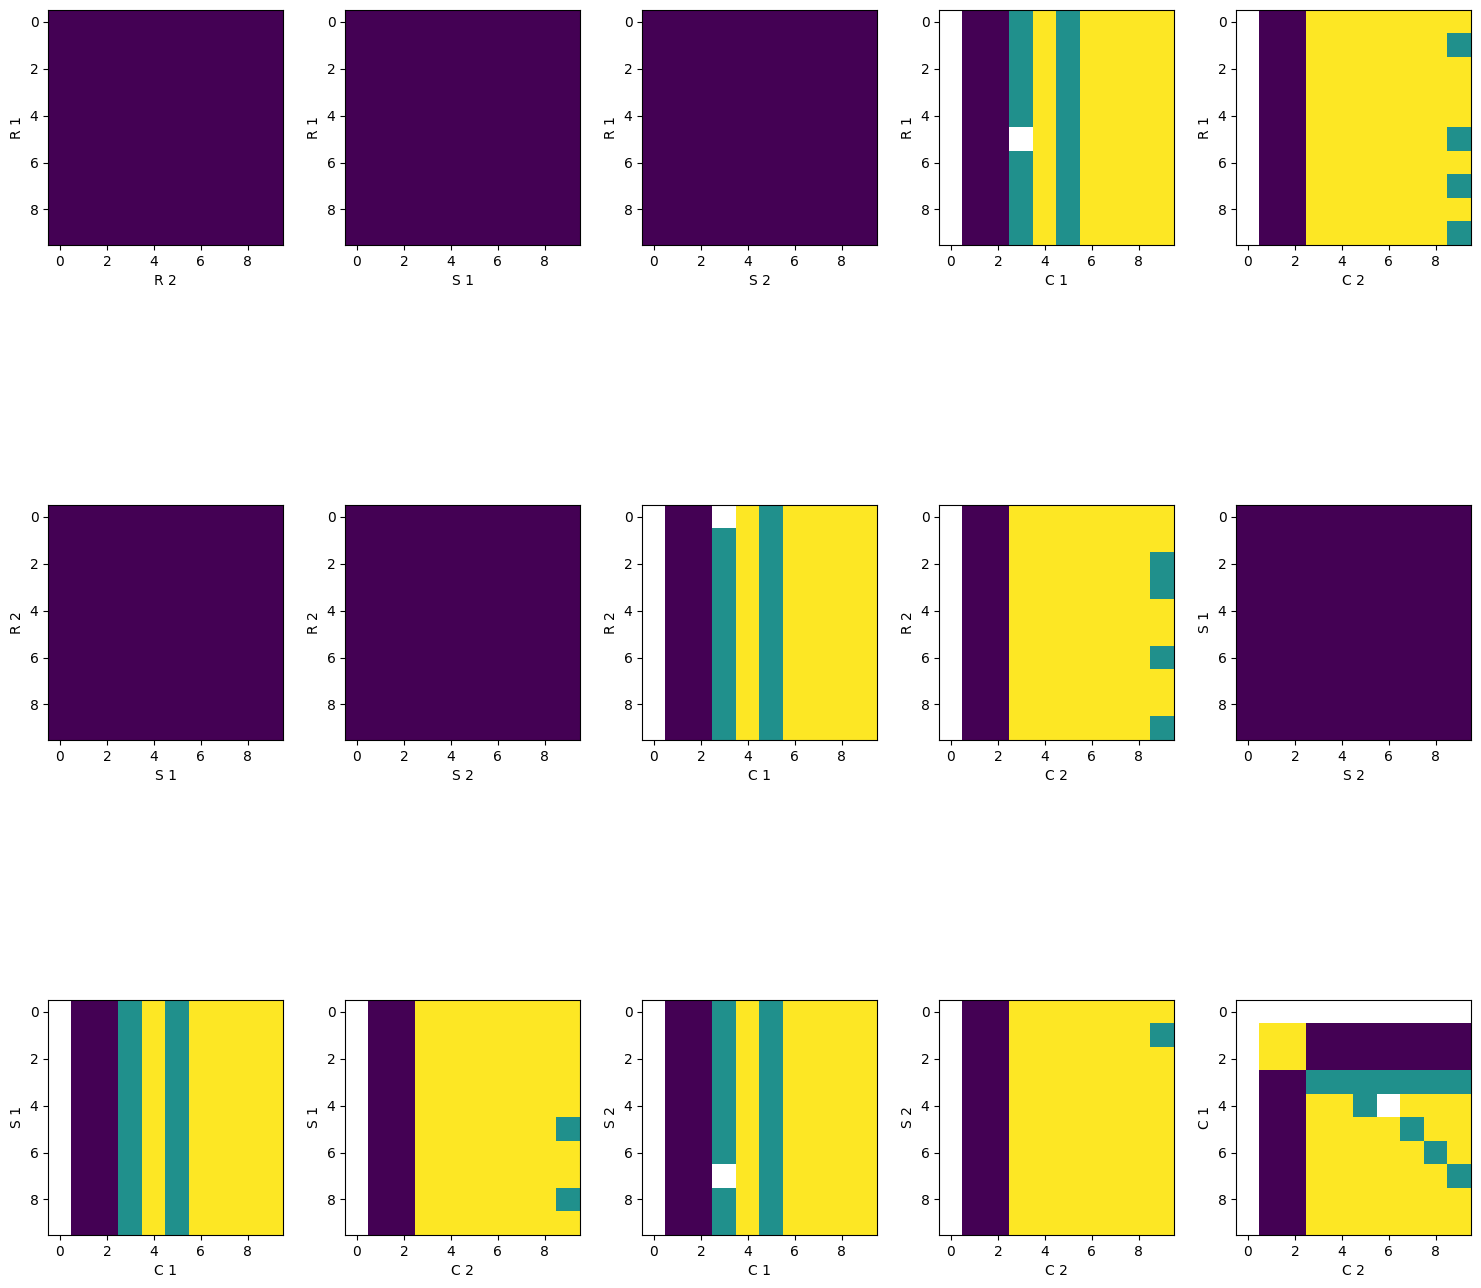

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(15,15))
plt.tight_layout()

cnt = 0
for i in range(3):
    for j in range(5):
        axs[i, j].imshow(BIF_MAPS_sgn[cnt])
        axs[i, j].set_xlabel(xlabels[cnt])
        axs[i, j].set_ylabel(ylabels[cnt])
        cnt += 1

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


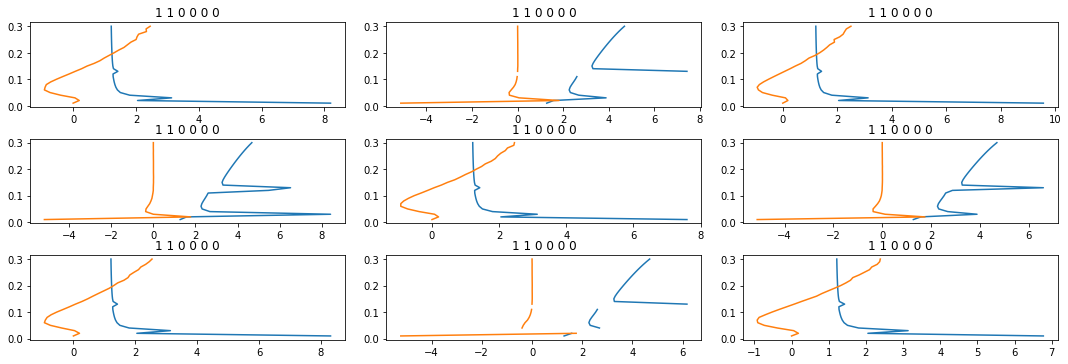

In [ ]:
d = {}
for i in range(len(plots)):
    d[i] = {'norm':plots[i][0], 
            'D':plots[i][1], 
            'name':plots[i][2]
           }
cnt = 9
needed = []
for i, elem in enumerate(plots):
    n, d, name = elem
    if np.all(name == np.array([1., 1., 0., 0., 0., 0.])):
        needed.append(i)
        cnt -= 1
    if not cnt:
        break
    
needed_plots = np.array(plots)[needed]

fig, axs = plt.subplots(3, 3, figsize=(15, 5))
plt.tight_layout()

c = np.linspace(C_1[0], C_1[1], 30)

for i, elem in enumerate(needed_plots):
    axs[i // 3, i % 3].plot(np.log(elem[0]), c)
    axs[i // 3, i % 3].plot(elem[1], c)
    axs[i // 3, i % 3].title.set_text(' '.join([str(int(i)) for i in elem[2]]));